In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [9]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [10]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [11]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [12]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [13]:
results_10.sort_values(by = 'year', inplace = True, ignore_index=True)

In [14]:
print(stats.kstest(results_10['0_10'], results_10['90_100']))
print(stats.kstest(results_10['10_20'], results_10['80_90']))
print(stats.kstest(results_10['20_30'], results_10['70_80']))
print(stats.kstest(results_10['30_40'], results_10['60_70']))
print(stats.kstest(results_10['40_50'], results_10['50_60']))

KstestResult(statistic=0.30594277329420394, pvalue=2.5563483388202393e-169, statistic_location=0.29577464788732394, statistic_sign=1)
KstestResult(statistic=0.3707507948153583, pvalue=2.0415681397968776e-250, statistic_location=0.059701492537313466, statistic_sign=1)
KstestResult(statistic=0.28295426754707753, pvalue=1.5133578758181105e-144, statistic_location=0.04545454545454547, statistic_sign=1)
KstestResult(statistic=0.17828319882611884, pvalue=3.6356332862499185e-57, statistic_location=0.0421052631578947, statistic_sign=1)
KstestResult(statistic=0.06260699437515285, pvalue=2.1713065302288394e-07, statistic_location=0.04166666666666666, statistic_sign=1)


two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

all have a p-value < 0.05

thus we reject H0, the distributions are not identical


In [15]:
bin_list = np.arange(0, 1.01, 0.01)

Text(0.5, 1.0, '2.5563483388202393e-169')

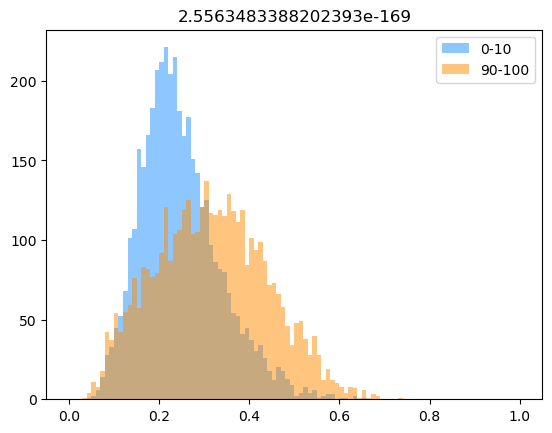

In [16]:
plt.hist(results_10['0_10'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '0-10')
plt.hist(results_10['90_100'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '90-100')
plt.legend()
plt.title(stats.kstest(results_10['0_10'], results_10['90_100']).pvalue)

Text(0.5, 1.0, '2.0415681397968776e-250')

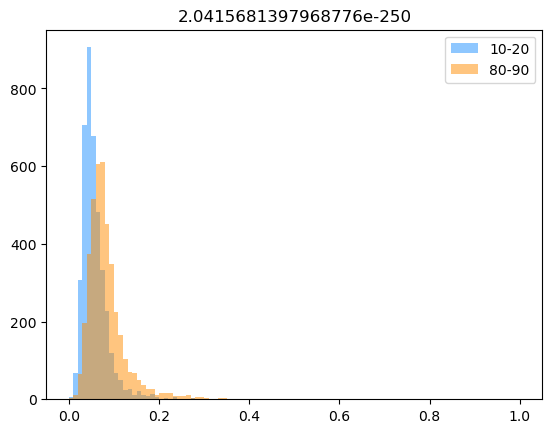

In [17]:
plt.hist(results_10['10_20'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '10-20')
plt.hist(results_10['80_90'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '80-90')
plt.legend()
plt.title(stats.kstest(results_10['10_20'], results_10['80_90']).pvalue)

Text(0.5, 1.0, '1.5133578758181105e-144')

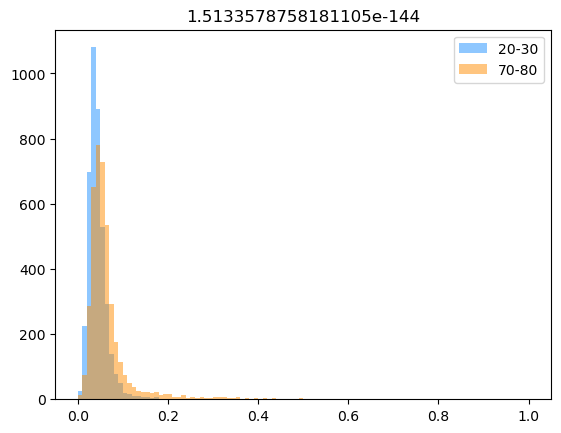

In [18]:
plt.hist(results_10['20_30'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '20-30')
plt.hist(results_10['70_80'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '70-80')
plt.legend()
plt.title(stats.kstest(results_10['20_30'], results_10['70_80']).pvalue)

Text(0.5, 1.0, '3.6356332862499185e-57')

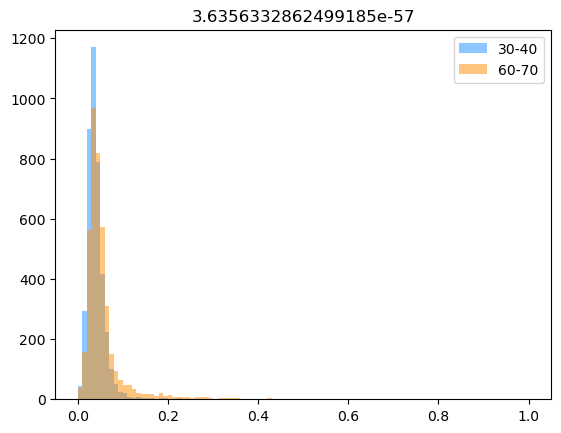

In [19]:
plt.hist(results_10['30_40'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '30-40')
plt.hist(results_10['60_70'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '60-70')
plt.legend()
plt.title(stats.kstest(results_10['30_40'], results_10['60_70']).pvalue)


Text(0.5, 1.0, '2.1713065302288394e-07')

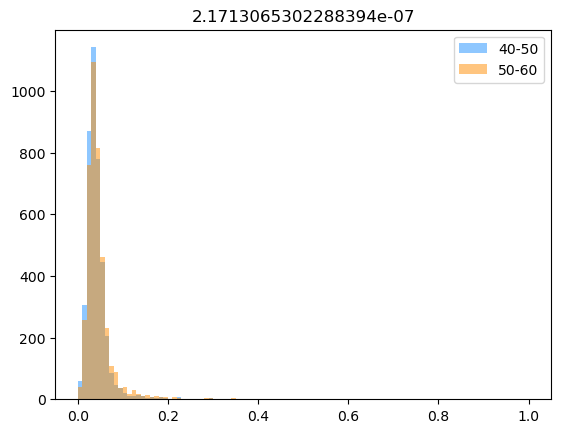

In [20]:
plt.hist(results_10['40_50'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '40-50')
plt.hist(results_10['50_60'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '50-60')
plt.legend()
plt.title(stats.kstest(results_10['40_50'], results_10['50_60']).pvalue)

In [23]:
for i in results_10.columns[6:]:
    for j in results_10.columns[6:]:
        #if i == j:
        print(i, j, stats.kstest(results_10[i], results_10[j]))
        plt.hist(results_10[i], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = i)
        plt.hist(results_10[j], bins = bin_list, alpha = 0.5, color = 'darkorange', label = j)
        plt.legend()
        plt.title(f'P value of KS: {stats.kstest(results_10[i], results_10[j]).pvalue}')
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/ks_test/{i}_{j}.png')
        plt.close()
            #plt.show()

0_10 0_10 KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.04648760330578512, statistic_sign=1)
0_10 10_20 KstestResult(statistic=0.9227194913181707, pvalue=0.0, statistic_location=0.10687022854433642, statistic_sign=-1)
0_10 20_30 KstestResult(statistic=0.9586696013695281, pvalue=0.0, statistic_location=0.09523809523809523, statistic_sign=-1)
0_10 30_40 KstestResult(statistic=0.9645390070921985, pvalue=0.0, statistic_location=0.08666666666666667, statistic_sign=-1)
0_10 40_50 KstestResult(statistic=0.9523110785033015, pvalue=0.0, statistic_location=0.0955056179775281, statistic_sign=-1)
0_10 50_60 KstestResult(statistic=0.9307899241868427, pvalue=0.0, statistic_location=0.09090909090909088, statistic_sign=-1)
0_10 60_70 KstestResult(statistic=0.896796282709709, pvalue=0.0, statistic_location=0.11608093716719914, statistic_sign=-1)
0_10 70_80 KstestResult(statistic=0.8811445341159208, pvalue=0.0, statistic_location=0.11281489594742611, statistic_sign=-1)
0_10 80_90 KstestRe

In [25]:
for i in results_10.columns[6:]:
    for j in results_10.columns[6:]:
        #if i == j:
        p_value = stats.kstest(results_10[i], results_10[j]).pvalue
        if p_value > 0.05 and i != j:
            print(i, j, stats.kstest(results_10[i], results_10[j]))

            #plt.show()

30_40 40_50 KstestResult(statistic=0.016140865737344093, pvalue=0.6612406143637579, statistic_location=0.04823151125401931, statistic_sign=1)
40_50 30_40 KstestResult(statistic=0.016140865737344093, pvalue=0.6612406143637579, statistic_location=0.04823151125401931, statistic_sign=-1)


In [22]:
i

'90_100'